# 🔬 Analyse Exploratoire des Données (EDA) - Prédiction du Taux de Grippe

---

## 📋 Introduction

**Objectif du projet** : Prédire le taux de grippe pour 100 000 habitants par région française pour des semaines spécifiques.

**Description du dataset** : Ce fichier `train_final.csv` est le résultat d'une fusion (merge) entre :
- Les données d'entraînement originales contenant les informations sur les cas de grippe par région et par semaine
- Des données démographiques et de population par région

Cette enrichissement du dataset permet d'améliorer les performances de prédiction en intégrant des caractéristiques démographiques pertinentes (tranches d'âge, population totale, etc.).

---

## 1. Import des Librairies

In [1]:
# Librairies de base
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Configuration des affichages
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Style des graphiques
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Ignorer les warnings
import warnings
warnings.filterwarnings('ignore')

print("✅ Toutes les librairies ont été importées avec succès !")

✅ Toutes les librairies ont été importées avec succès !


## 2. Fonctions Utilitaires

Fonctions personnalisées pour l'analyse des données.

In [2]:
##############################################################################################
# FONCTION : Affiche le taux de valeurs manquantes de chaque variable
#            par ordre décroissant
###############################################################################################         
def taux_missing_values(df):
    """Affiche le taux de valeurs manquantes par variable (ordre décroissant)."""
    missing_values = df.isnull().mean() * 100
    missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
    if missing_values.empty:        
        print("✅ Il n'y a pas de valeurs manquantes dans le dataset.")
    else:
        print("📊 Taux de valeurs manquantes par variable :")
        print("-" * 50)
        for col, val in missing_values.items():
            print(f"{col:<60} : {val:.2f}%")
    return missing_values


#################################################################################################
# FONCTION : Retourne 0 ou 1 si la valeur observée est outlier ou pas (méthode IQR)
##################################################################################################
def is_outlier(df, column):
    """Détecte les outliers avec la méthode IQR. Retourne 1 si outlier, 0 sinon."""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    limite_inf = Q1 - 1.5 * IQR
    limite_sup = Q3 + 1.5 * IQR
    series = df[column].apply(lambda x: 1 if (x < limite_inf or x > limite_sup) else 0)
    return series


###########################################################################################################
# FONCTION : Affiche le taux ET le nombre de valeurs manquantes de chaque variable
###########################################################################################################
def taux_missing_values_nb(df):
    """Affiche le taux et le nombre de valeurs manquantes par variable."""
    missing_values = df.isnull().mean() * 100
    missing_values_nb = df.isnull().sum()
    missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
    if missing_values.empty:        
        print("✅ Il n'y a pas de valeurs manquantes dans le dataset.")
    else:
        print("📊 Taux de valeurs manquantes par variable :")
        print("-" * 50)
        for col, val in missing_values.items():
            nb = missing_values_nb[col]
            print(f"{col:<60} : {val:.2f}% ({nb} valeurs)")


###########################################################################################################
# FONCTION ADDITIONNELLE : Résumé complet des outliers
###########################################################################################################
def outliers_summary(df, numeric_cols):
    """Affiche un résumé des outliers pour chaque variable numérique."""
    print("📊 Résumé des Outliers (méthode IQR) :")
    print("-" * 70)
    results = []
    for col in numeric_cols:
        if df[col].notna().sum() > 0:
            outlier_mask = is_outlier(df, col)
            nb_outliers = outlier_mask.sum()
            pct_outliers = (nb_outliers / len(df)) * 100
            results.append({'Variable': col, 'Nb Outliers': nb_outliers, '% Outliers': pct_outliers})
    
    results_df = pd.DataFrame(results).sort_values('% Outliers', ascending=False)
    return results_df

print("✅ Fonctions utilitaires chargées !")

✅ Fonctions utilitaires chargées !


## 3. Chargement du Dataset

In [14]:
# Chargement du dataset
df = pd.read_csv('C:\\Users\\maeva\\OneDrive\\Alternance\\cours_MOSEF\\Kaggle\\flu-prediction\\data\\processed\\train_final.csv')

print(f"✅ Dataset chargé avec succès !")
print(f"📐 Dimensions : {df.shape[0]} lignes × {df.shape[1]} colonnes")

✅ Dataset chargé avec succès !
📐 Dimensions : 9196 lignes × 24 colonnes


In [15]:
# Aperçu des premières lignes
print("🔍 Aperçu des 5 premières lignes :")
df.head()

🔍 Aperçu des 5 premières lignes :


,Id,week,region_code,region_name,TauxGrippe,year,Mois_x,month,region_normalized,region,pop_0_19,pop_20_39,pop_40_59,pop_60_74,pop_75_plus,pop_total,Mois_y,requete_grippe_x,requete_grippe_aviaire_vaccin_x,requete_grippe_aviaire_vaccin_porcine_porc_H1N1_AH1N1_A_mexicaine_Mexique_pandemie_x,Mois,requete_grippe_y,requete_grippe_aviaire_vaccin_y,requete_grippe_aviaire_vaccin_porcine_porc_H1N1_AH1N1_A_mexicaine_Mexique_pandemie_y
0,5523,201152,42,ALSACE,66,2011,12,2011-12-01,ALSACE,Alsace,448112,479905,526481,250849,146978,1852325,2011-12,2.00,2.00,2.00,2011-12,2.00,2.00,2.00
1,5524,201152,72,AQUITAINE,24,2011,12,2011-12-01,AQUITAINE,Aquitaine,732120,765143,896030,516065,344875,3254233,2011-12,2.00,2.00,2.00,2011-12,2.00,2.00,2.00
2,5525,201152,83,AUVERGNE,91,2011,12,2011-12-01,AUVERGNE,Auvergne,294709,305778,375485,223830,150880,1350682,2011-12,3.00,3.00,2.00,2011-12,3.00,3.00,2.00
3,5526,201152,25,BASSE-NORMANDIE,49,2011,12,2011-12-01,BASSENORMANDIE,Basse-Normandie,354514,336201,401766,228888,154315,1475684,2011-12,2.00,2.00,2.00,2011-12,2.00,2.00,2.00
4,5527,201152,26,BOURGOGNE,33,2011,12,2011-12-01,BOURGOGNE,Bourgogne,372023,369737,450664,269109,181201,1642734,2011-12,2.00,2.00,1.00,2011-12,2.00,2.00,1.00


In [16]:
# Aperçu des dernières lignes
print("🔍 Aperçu des 5 dernières lignes :")
df.tail()

🔍 Aperçu des 5 dernières lignes :


,Id,week,region_code,region_name,TauxGrippe,year,Mois_x,month,region_normalized,region,pop_0_19,pop_20_39,pop_40_59,pop_60_74,pop_75_plus,pop_total,Mois_y,requete_grippe_x,requete_grippe_aviaire_vaccin_x,requete_grippe_aviaire_vaccin_porcine_porc_H1N1_AH1N1_A_mexicaine_Mexique_pandemie_x,Mois,requete_grippe_y,requete_grippe_aviaire_vaccin_y,requete_grippe_aviaire_vaccin_porcine_porc_H1N1_AH1N1_A_mexicaine_Mexique_pandemie_y
9191,14714,200401,22,PICARDIE,25,2004,1,2004-01-01,PICARDIE,Picardie,510580,504779,518419,219485,130146,1883409,2004-01,7.00,7.00,7.00,2004-01,7.00,7.00,7.00
9192,14715,200401,54,POITOU-CHARENTES,100,2004,1,2004-01-01,POITOUCHARENTES,Poitou-Charentes,387823,414368,467948,256875,171006,1698020,2004-01,3.00,3.00,3.00,2004-01,3.00,3.00,3.00
9193,14716,200401,93,PROVENCE-ALPES-COTE-D-AZUR,293,2004,1,2004-01-01,PROVENCEALPESCOTEDAZUR,Provence-Alpes-Côte d'Azur,1127581,1187177,1279079,691333,433962,4719132,2004-01,6.00,6.00,6.00,2004-01,6.00,6.00,6.00
9194,14717,200401,11,ILE-DE-FRANCE,66,2004,1,2004-01-01,ILEDEFRANCE,Île-de-France,2970969,3493848,3063842,1166374,655257,11350290,2004-01,7.00,5.00,5.00,2004-01,7.00,5.00,5.00
9195,14718,200401,82,RHONE-ALPES,358,2004,1,2004-01-01,RHONEALPES,Rhône-Alpes,1530256,1621106,1586950,738439,427978,5904729,2004-01,5.00,4.00,4.00,2004-01,5.00,4.00,4.00


## 4. Description du Dataset

In [17]:
# Informations générales sur le dataset
print("📋 INFORMATIONS GÉNÉRALES SUR LE DATASET")
print("=" * 60)
print(f"\n📐 Nombre de lignes    : {df.shape[0]:,}")
print(f"📐 Nombre de colonnes  : {df.shape[1]}")
print(f"💾 Taille en mémoire   : {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\n" + "=" * 60)
print("\n📝 Liste des colonnes :")
for i, col in enumerate(df.columns, 1):
    print(f"  {i:2d}. {col}")

📋 INFORMATIONS GÉNÉRALES SUR LE DATASET

📐 Nombre de lignes    : 9,196
📐 Nombre de colonnes  : 24
💾 Taille en mémoire   : 4.38 MB


📝 Liste des colonnes :
   1. Id
   2. week
   3. region_code
   4. region_name
   5. TauxGrippe
   6. year
   7. Mois_x
   8. month
   9. region_normalized
  10. region
  11. pop_0_19
  12. pop_20_39
  13. pop_40_59
  14. pop_60_74
  15. pop_75_plus
  16. pop_total
  17. Mois_y
  18. requete_grippe_x
  19. requete_grippe_aviaire_vaccin_x
  20. requete_grippe_aviaire_vaccin_porcine_porc_H1N1_AH1N1_A_mexicaine_Mexique_pandemie_x
  21. Mois
  22. requete_grippe_y
  23. requete_grippe_aviaire_vaccin_y
  24. requete_grippe_aviaire_vaccin_porcine_porc_H1N1_AH1N1_A_mexicaine_Mexique_pandemie_y


In [18]:
# Types des variables
print("📊 TYPES DES VARIABLES")
print("=" * 60)
print(df.dtypes)

📊 TYPES DES VARIABLES
Id                                                                                        int64
week                                                                                      int64
region_code                                                                               int64
region_name                                                                              object
TauxGrippe                                                                                int64
year                                                                                      int64
Mois_x                                                                                    int64
month                                                                                    object
region_normalized                                                                        object
region                                                                                   object
pop_0_19          

In [19]:
# Info détaillée
print("📊 INFO DÉTAILLÉE DU DATASET")
print("=" * 60)
df.info()

📊 INFO DÉTAILLÉE DU DATASET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9196 entries, 0 to 9195
Data columns (total 24 columns):
 #   Column                                                                                Non-Null Count  Dtype  
---  ------                                                                                --------------  -----  
 0   Id                                                                                    9196 non-null   int64  
 1   week                                                                                  9196 non-null   int64  
 2   region_code                                                                           9196 non-null   int64  
 3   region_name                                                                           9196 non-null   object 
 4   TauxGrippe                                                                            9196 non-null   int64  
 5   year                                                   

## 5. Identification des Variables Numériques et Catégorielles

In [20]:
# Séparation des variables numériques et catégorielles
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print("📊 IDENTIFICATION DES TYPES DE VARIABLES")
print("=" * 60)

print(f"\n🔢 Variables NUMÉRIQUES ({len(numeric_cols)}) :")
print("-" * 40)
for col in numeric_cols:
    print(f"  • {col}")

print(f"\n📝 Variables CATÉGORIELLES ({len(categorical_cols)}) :")
print("-" * 40)
for col in categorical_cols:
    print(f"  • {col}")

📊 IDENTIFICATION DES TYPES DE VARIABLES

🔢 Variables NUMÉRIQUES (18) :
----------------------------------------
  • Id
  • week
  • region_code
  • TauxGrippe
  • year
  • Mois_x
  • pop_0_19
  • pop_20_39
  • pop_40_59
  • pop_60_74
  • pop_75_plus
  • pop_total
  • requete_grippe_x
  • requete_grippe_aviaire_vaccin_x
  • requete_grippe_aviaire_vaccin_porcine_porc_H1N1_AH1N1_A_mexicaine_Mexique_pandemie_x
  • requete_grippe_y
  • requete_grippe_aviaire_vaccin_y
  • requete_grippe_aviaire_vaccin_porcine_porc_H1N1_AH1N1_A_mexicaine_Mexique_pandemie_y

📝 Variables CATÉGORIELLES (6) :
----------------------------------------
  • region_name
  • month
  • region_normalized
  • region
  • Mois_y
  • Mois


In [21]:
# Analyse des modalités des variables catégorielles
print("📊 ANALYSE DES VARIABLES CATÉGORIELLES")
print("=" * 60)

for col in categorical_cols:
    n_unique = df[col].nunique()
    print(f"\n🏷️ {col} : {n_unique} modalités uniques")
    if n_unique <= 25:  # Afficher les modalités si pas trop nombreuses
        print(f"   Modalités : {df[col].unique()[:10]}..." if n_unique > 10 else f"   Modalités : {df[col].unique()}")

📊 ANALYSE DES VARIABLES CATÉGORIELLES

🏷️ region_name : 22 modalités uniques
   Modalités : ['ALSACE' 'AQUITAINE' 'AUVERGNE' 'BASSE-NORMANDIE' 'BOURGOGNE' 'BRETAGNE'
 'CENTRE' 'CHAMPAGNE-ARDENNE' 'CORSE' 'FRANCHE-COMTE']...

🏷️ month : 96 modalités uniques

🏷️ region_normalized : 22 modalités uniques
   Modalités : ['ALSACE' 'AQUITAINE' 'AUVERGNE' 'BASSENORMANDIE' 'BOURGOGNE' 'BRETAGNE'
 'CENTRE' 'CHAMPAGNEARDENNE' 'CORSE' 'FRANCHECOMTE']...

🏷️ region : 22 modalités uniques
   Modalités : ['Alsace' 'Aquitaine' 'Auvergne' 'Basse-Normandie' 'Bourgogne' 'Bretagne'
 'Centre' 'Champagne-Ardenne' 'Corse' 'Franche-Comté']...

🏷️ Mois_y : 96 modalités uniques

🏷️ Mois : 96 modalités uniques


## 6. Analyse Descriptive

In [22]:
# Statistiques descriptives des variables numériques
print("📊 STATISTIQUES DESCRIPTIVES - VARIABLES NUMÉRIQUES")
print("=" * 60)
df[numeric_cols].describe().T

📊 STATISTIQUES DESCRIPTIVES - VARIABLES NUMÉRIQUES


,count,mean,std,min,25%,50%,75%,max
Id,9196.00,10120.50,2654.80,5523.00,7821.75,10120.50,12419.25,14718.00
week,9196.00,200776.15,229.79,200401.00,200552.00,200776.50,200953.00,201152.00
region_code,9196.00,51.36,26.51,11.00,25.00,47.50,74.00,94.00
TauxGrippe,9196.00,77.55,180.94,0.00,0.00,10.00,59.00,2478.00
year,9196.00,2007.50,2.29,2004.00,2005.00,2007.50,2009.00,2011.00
Mois_x,9196.00,6.47,3.45,1.00,3.00,6.00,9.00,12.00
pop_0_19,9196.00,696445.80,611297.41,61737.00,360474.00,533070.50,764057.75,3071017.00
pop_20_39,9196.00,733801.50,696461.36,71611.00,353576.00,550470.00,773656.00,3508802.00
pop_40_59,9196.00,768348.14,623514.35,79994.00,404851.75,589058.00,892061.00,3138930.00
pop_60_74,9196.00,375331.21,264212.97,44827.00,215662.00,297194.50,447151.25,1383699.00


In [23]:
# Statistiques descriptives étendues
print("📊 STATISTIQUES DESCRIPTIVES ÉTENDUES")
print("=" * 60)

stats_df = pd.DataFrame({
    'Type': df[numeric_cols].dtypes,
    'Count': df[numeric_cols].count(),
    'Missing': df[numeric_cols].isnull().sum(),
    'Missing %': (df[numeric_cols].isnull().sum() / len(df) * 100).round(2),
    'Unique': df[numeric_cols].nunique(),
    'Mean': df[numeric_cols].mean().round(2),
    'Std': df[numeric_cols].std().round(2),
    'Min': df[numeric_cols].min(),
    'Q25': df[numeric_cols].quantile(0.25),
    'Median': df[numeric_cols].median(),
    'Q75': df[numeric_cols].quantile(0.75),
    'Max': df[numeric_cols].max(),
    'Skewness': df[numeric_cols].skew().round(2),
    'Kurtosis': df[numeric_cols].kurtosis().round(2)
})

stats_df

📊 STATISTIQUES DESCRIPTIVES ÉTENDUES


,Type,Count,Missing,Missing %,Unique,Mean,Std,Min,Q25,Median,Q75,Max,Skewness,Kurtosis
Id,int64,9196,0,0.00,9196,10120.50,2654.80,5523.00,7821.75,10120.50,12419.25,14718.00,0.00,-1.20
week,int64,9196,0,0.00,418,200776.15,229.79,200401.00,200552.00,200776.50,200953.00,201152.00,-0.00,-1.23
region_code,int64,9196,0,0.00,22,51.36,26.51,11.00,25.00,47.50,74.00,94.00,0.23,-1.36
TauxGrippe,int64,9196,0,0.00,738,77.55,180.94,0.00,0.00,10.00,59.00,2478.00,4.34,25.68
year,int64,9196,0,0.00,8,2007.50,2.29,2004.00,2005.00,2007.50,2009.00,2011.00,-0.00,-1.24
Mois_x,int64,9196,0,0.00,12,6.47,3.45,1.00,3.00,6.00,9.00,12.00,-0.00,-1.21
pop_0_19,int64,9196,0,0.00,176,696445.80,611297.41,61737.00,360474.00,533070.50,764057.75,3071017.00,2.53,6.89
pop_20_39,int64,9196,0,0.00,176,733801.50,696461.36,71611.00,353576.00,550470.00,773656.00,3508802.00,2.84,8.53
pop_40_59,int64,9196,0,0.00,176,768348.14,623514.35,79994.00,404851.75,589058.00,892061.00,3138930.00,2.44,6.54
pop_60_74,int64,9196,0,0.00,176,375331.21,264212.97,44827.00,215662.00,297194.50,447151.25,1383699.00,1.82,3.58


In [24]:
# Focus sur la variable cible : TauxGrippe
print("🎯 ANALYSE DE LA VARIABLE CIBLE : TauxGrippe")
print("=" * 60)

print(f"\n📈 Statistiques :")
print(f"   Moyenne          : {df['TauxGrippe'].mean():.2f}")
print(f"   Médiane          : {df['TauxGrippe'].median():.2f}")
print(f"   Écart-type       : {df['TauxGrippe'].std():.2f}")
print(f"   Minimum          : {df['TauxGrippe'].min()}")
print(f"   Maximum          : {df['TauxGrippe'].max()}")
print(f"   Coefficient var. : {(df['TauxGrippe'].std() / df['TauxGrippe'].mean() * 100):.2f}%")

🎯 ANALYSE DE LA VARIABLE CIBLE : TauxGrippe

📈 Statistiques :
   Moyenne          : 77.55
   Médiane          : 10.00
   Écart-type       : 180.94
   Minimum          : 0
   Maximum          : 2478
   Coefficient var. : 233.31%


## 7. Analyse des Distributions

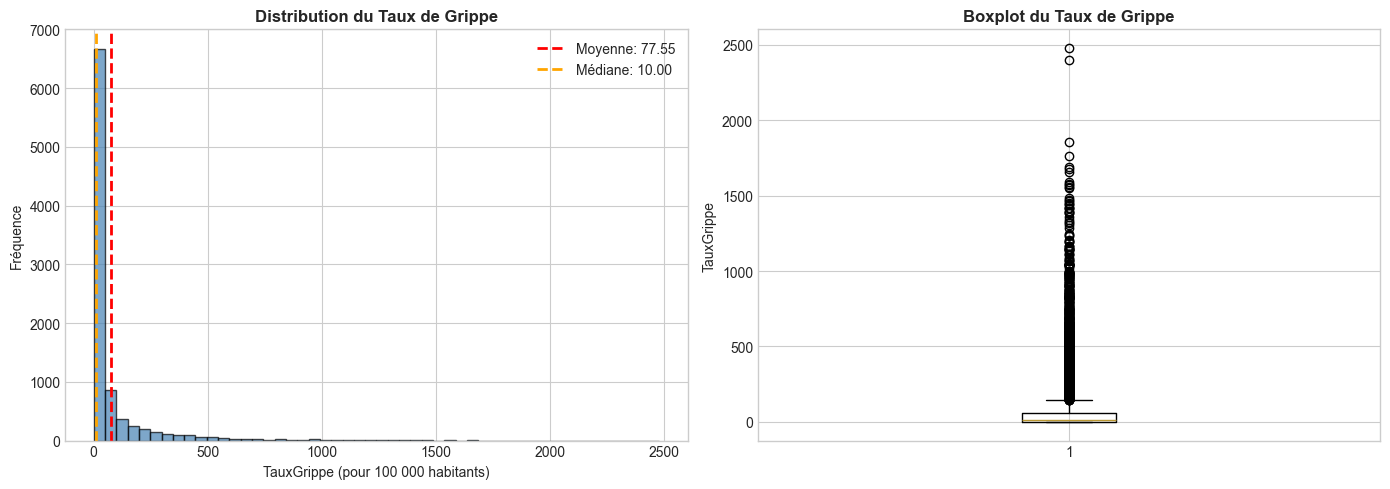

📊 La distribution du taux de grippe présente une asymétrie positive (queue à droite).


In [25]:
# Distribution de la variable cible
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogramme
axes[0].hist(df['TauxGrippe'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(df['TauxGrippe'].mean(), color='red', linestyle='--', linewidth=2, label=f'Moyenne: {df["TauxGrippe"].mean():.2f}')
axes[0].axvline(df['TauxGrippe'].median(), color='orange', linestyle='--', linewidth=2, label=f'Médiane: {df["TauxGrippe"].median():.2f}')
axes[0].set_xlabel('TauxGrippe (pour 100 000 habitants)')
axes[0].set_ylabel('Fréquence')
axes[0].set_title('Distribution du Taux de Grippe', fontsize=12, fontweight='bold')
axes[0].legend()

# Boxplot
axes[1].boxplot(df['TauxGrippe'].dropna(), vert=True)
axes[1].set_ylabel('TauxGrippe')
axes[1].set_title('Boxplot du Taux de Grippe', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('distribution_taux_grippe.png', dpi=150, bbox_inches='tight')
plt.show()

print("📊 La distribution du taux de grippe présente une asymétrie positive (queue à droite).")

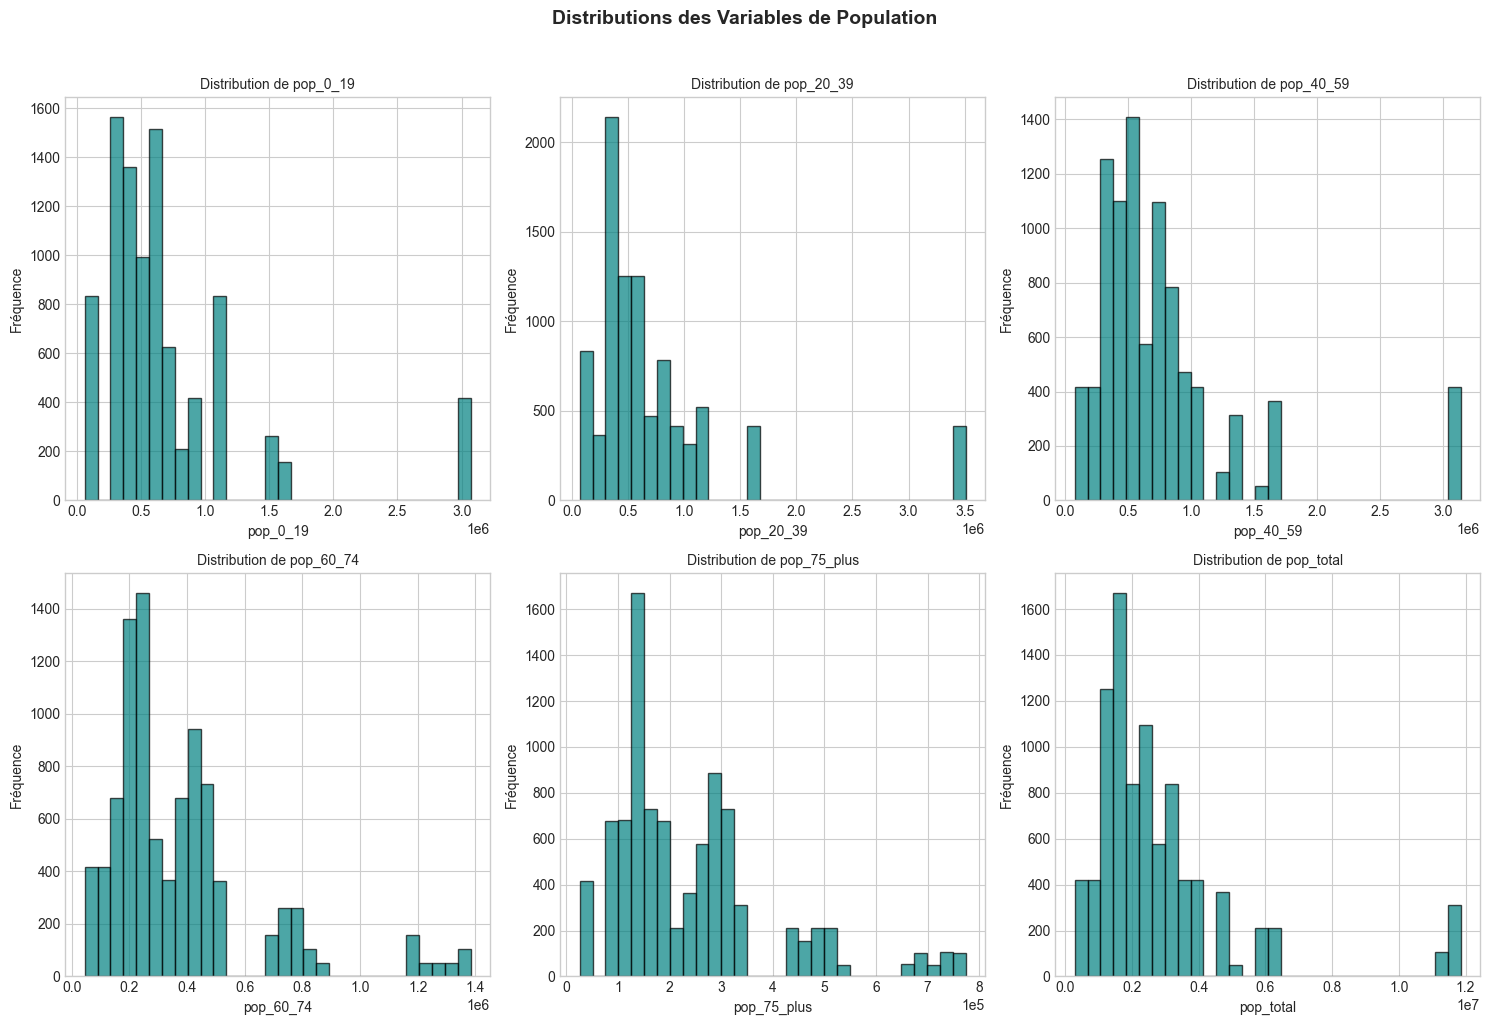

In [26]:
# Distributions des variables de population
pop_cols = ['pop_0_19', 'pop_20_39', 'pop_40_59', 'pop_60_74', 'pop_75_plus', 'pop_total']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(pop_cols):
    axes[i].hist(df[col].dropna(), bins=30, edgecolor='black', alpha=0.7, color='teal')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Fréquence')
    axes[i].set_title(f'Distribution de {col}', fontsize=10)
    axes[i].ticklabel_format(style='scientific', axis='x', scilimits=(0,0))

plt.suptitle('Distributions des Variables de Population', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('distribution_population.png', dpi=150, bbox_inches='tight')
plt.show()

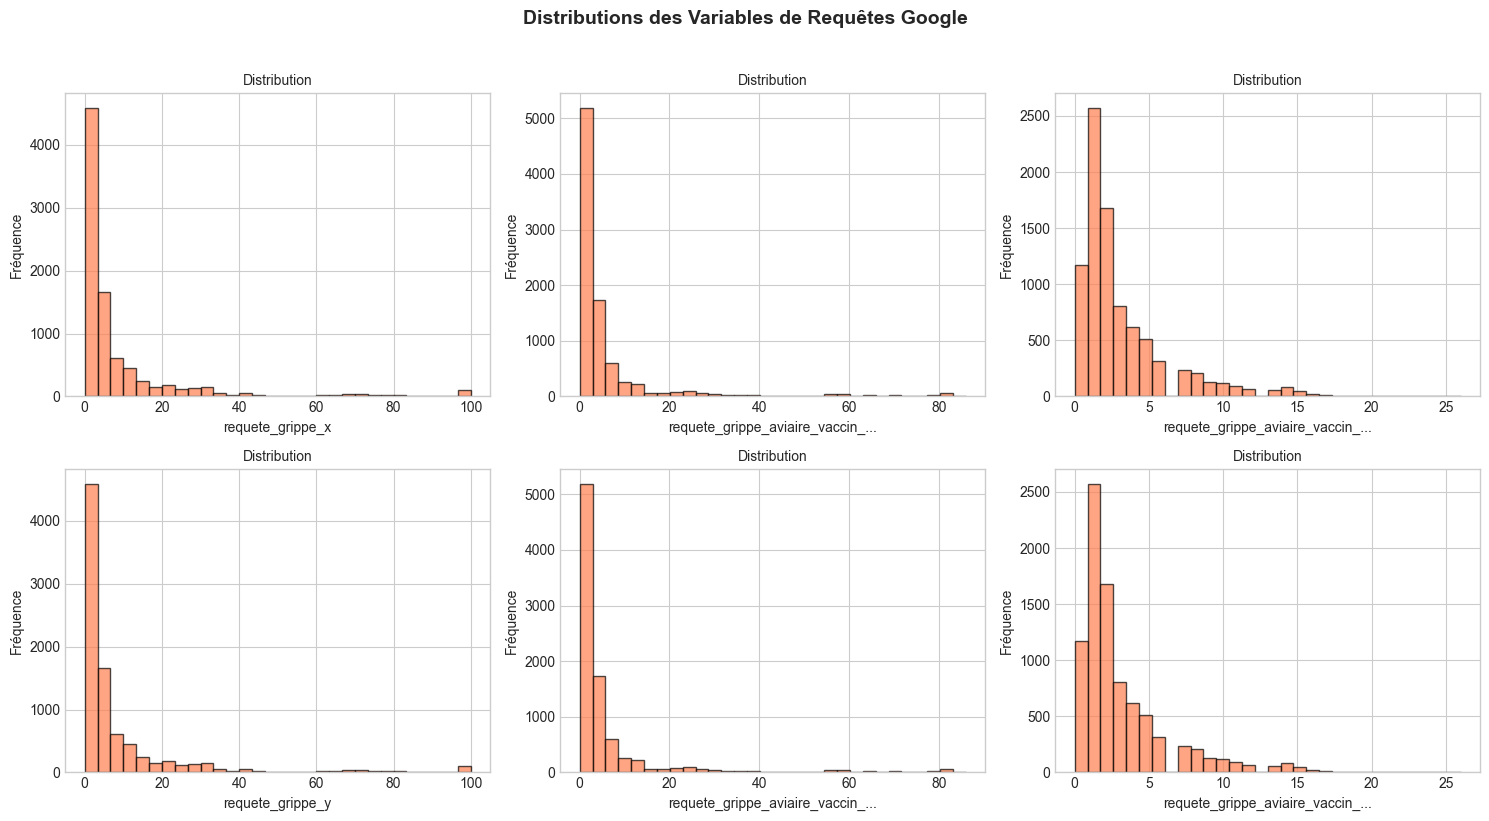

In [27]:
# Distributions des variables de requêtes Google
requete_cols = [col for col in numeric_cols if 'requete' in col.lower()]

if requete_cols:
    n_cols = len(requete_cols)
    n_rows = (n_cols + 2) // 3
    
    fig, axes = plt.subplots(n_rows, 3, figsize=(15, 4*n_rows))
    axes = axes.flatten() if n_cols > 1 else [axes]
    
    for i, col in enumerate(requete_cols):
        axes[i].hist(df[col].dropna(), bins=30, edgecolor='black', alpha=0.7, color='coral')
        axes[i].set_xlabel(col[:30] + '...' if len(col) > 30 else col)
        axes[i].set_ylabel('Fréquence')
        axes[i].set_title(f'Distribution', fontsize=10)
    
    # Cacher les axes vides
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.suptitle('Distributions des Variables de Requêtes Google', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('distribution_requetes.png', dpi=150, bbox_inches='tight')
    plt.show()

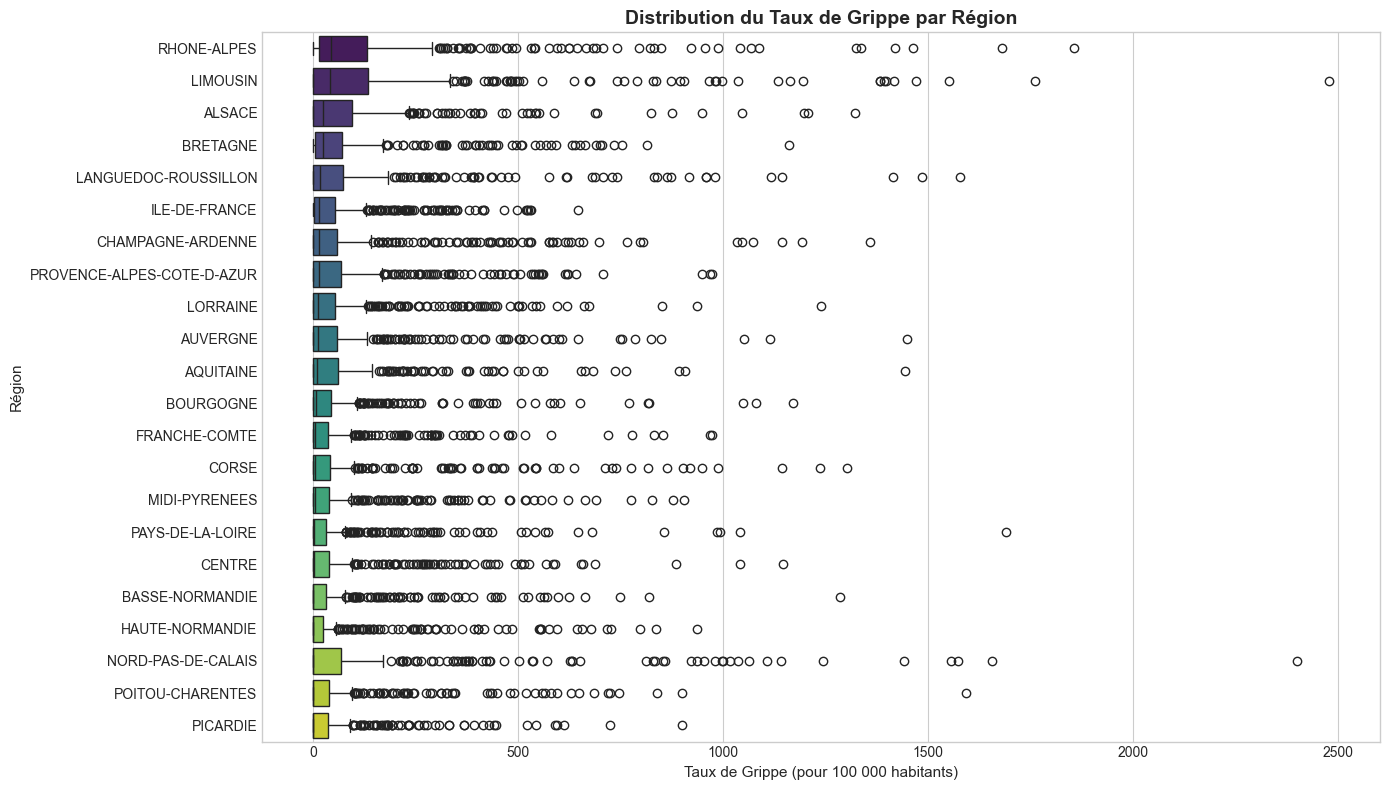

In [28]:
# Distribution du TauxGrippe par région
plt.figure(figsize=(14, 8))

# Trier par médiane
order = df.groupby('region_name')['TauxGrippe'].median().sort_values(ascending=False).index

sns.boxplot(data=df, x='TauxGrippe', y='region_name', order=order, palette='viridis')
plt.xlabel('Taux de Grippe (pour 100 000 habitants)', fontsize=11)
plt.ylabel('Région', fontsize=11)
plt.title('Distribution du Taux de Grippe par Région', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('distribution_grippe_region.png', dpi=150, bbox_inches='tight')
plt.show()

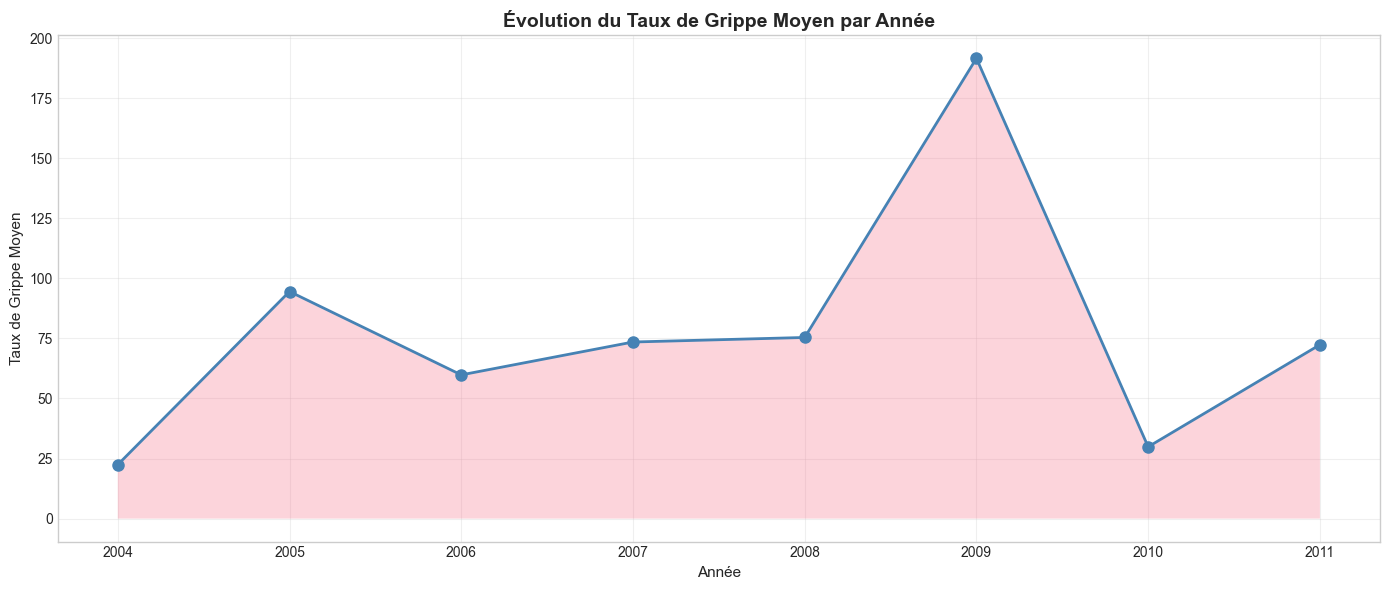

In [29]:
# Évolution temporelle du taux de grippe
df_temp = df.copy()
df_temp['year'] = df_temp['year'].astype(int)

plt.figure(figsize=(14, 6))
yearly_avg = df_temp.groupby('year')['TauxGrippe'].mean()
plt.plot(yearly_avg.index, yearly_avg.values, marker='o', linewidth=2, markersize=8, color='steelblue')
plt.fill_between(yearly_avg.index, yearly_avg.values, alpha=0.3)
plt.xlabel('Année', fontsize=11)
plt.ylabel('Taux de Grippe Moyen', fontsize=11)
plt.title('Évolution du Taux de Grippe Moyen par Année', fontsize=14, fontweight='bold')
plt.xticks(yearly_avg.index)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('evolution_temporelle.png', dpi=150, bbox_inches='tight')
plt.show()

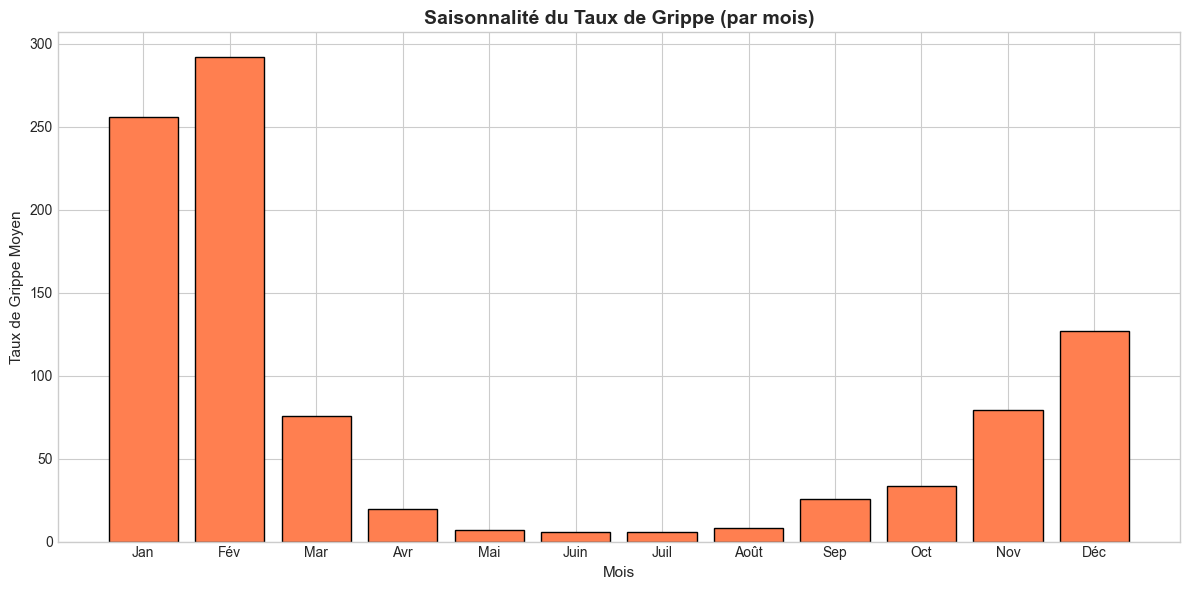

📊 On observe clairement un pic hivernal (décembre-février) caractéristique de l'épidémie de grippe.


In [30]:
# Saisonnalité : Taux de grippe par mois
plt.figure(figsize=(12, 6))

monthly_avg = df.groupby('Mois_x')['TauxGrippe'].mean().sort_index()
month_labels = ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Juin', 'Juil', 'Août', 'Sep', 'Oct', 'Nov', 'Déc']

plt.bar(range(1, 13), [monthly_avg.get(i, 0) for i in range(1, 13)], color='coral', edgecolor='black')
plt.xticks(range(1, 13), month_labels)
plt.xlabel('Mois', fontsize=11)
plt.ylabel('Taux de Grippe Moyen', fontsize=11)
plt.title('Saisonnalité du Taux de Grippe (par mois)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('saisonnalite.png', dpi=150, bbox_inches='tight')
plt.show()

print("📊 On observe clairement un pic hivernal (décembre-février) caractéristique de l'épidémie de grippe.")

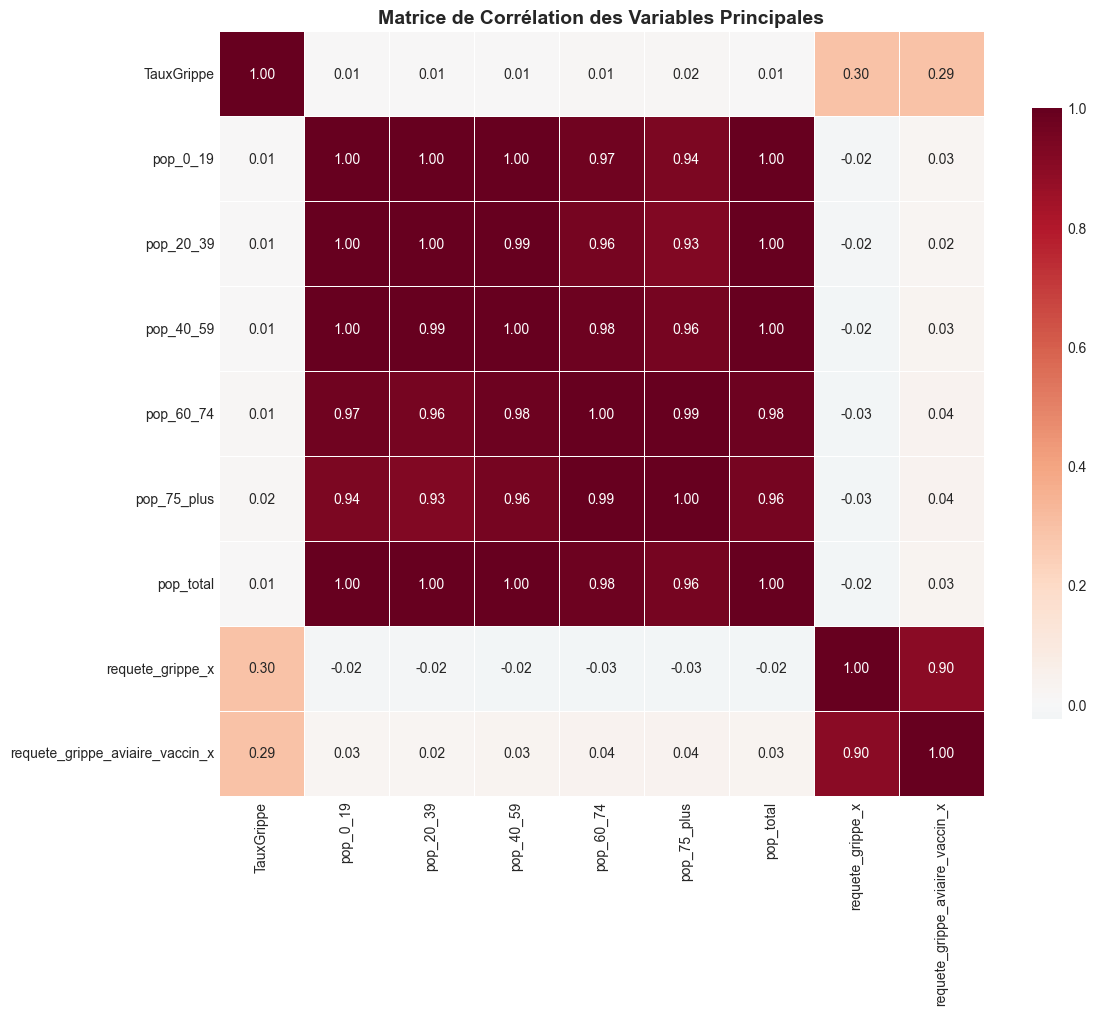

In [31]:
# Matrice de corrélation
# Sélectionner les variables numériques principales pour la corrélation
corr_cols = ['TauxGrippe', 'pop_0_19', 'pop_20_39', 'pop_40_59', 'pop_60_74', 'pop_75_plus', 'pop_total', 
             'requete_grippe_x', 'requete_grippe_aviaire_vaccin_x']
corr_cols = [c for c in corr_cols if c in df.columns]

plt.figure(figsize=(12, 10))
correlation_matrix = df[corr_cols].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, 
            fmt='.2f', linewidths=0.5, square=True,
            cbar_kws={'shrink': 0.8})
plt.title('Matrice de Corrélation des Variables Principales', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Analyse des Valeurs Manquantes

In [32]:
# Utilisation de la fonction personnalisée
print("📊 ANALYSE DES VALEURS MANQUANTES")
print("=" * 60)
missing_rates = taux_missing_values(df)

📊 ANALYSE DES VALEURS MANQUANTES
📊 Taux de valeurs manquantes par variable :
--------------------------------------------------
Mois_y                                                       : 4.55%
requete_grippe_x                                             : 4.55%
requete_grippe_aviaire_vaccin_x                              : 4.55%
requete_grippe_aviaire_vaccin_porcine_porc_H1N1_AH1N1_A_mexicaine_Mexique_pandemie_x : 4.55%
Mois                                                         : 4.55%
requete_grippe_y                                             : 4.55%
requete_grippe_aviaire_vaccin_y                              : 4.55%
requete_grippe_aviaire_vaccin_porcine_porc_H1N1_AH1N1_A_mexicaine_Mexique_pandemie_y : 4.55%


In [33]:
# Analyse détaillée avec nombre de valeurs
print("\n📊 DÉTAIL DES VALEURS MANQUANTES (Taux + Nombre)")
print("=" * 60)
taux_missing_values_nb(df)


📊 DÉTAIL DES VALEURS MANQUANTES (Taux + Nombre)
📊 Taux de valeurs manquantes par variable :
--------------------------------------------------
Mois_y                                                       : 4.55% (418 valeurs)
requete_grippe_x                                             : 4.55% (418 valeurs)
requete_grippe_aviaire_vaccin_x                              : 4.55% (418 valeurs)
requete_grippe_aviaire_vaccin_porcine_porc_H1N1_AH1N1_A_mexicaine_Mexique_pandemie_x : 4.55% (418 valeurs)
Mois                                                         : 4.55% (418 valeurs)
requete_grippe_y                                             : 4.55% (418 valeurs)
requete_grippe_aviaire_vaccin_y                              : 4.55% (418 valeurs)
requete_grippe_aviaire_vaccin_porcine_porc_H1N1_AH1N1_A_mexicaine_Mexique_pandemie_y : 4.55% (418 valeurs)


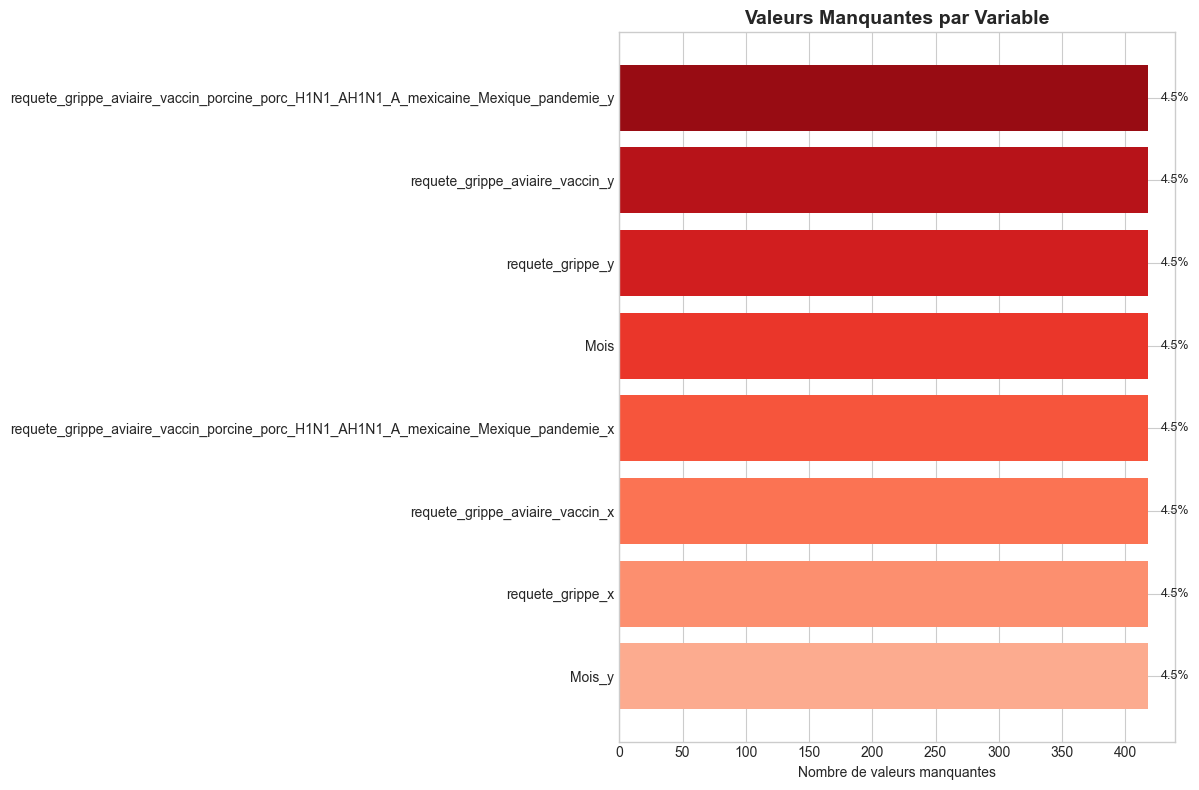

In [34]:
# Visualisation des valeurs manquantes
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=True)

if not missing_data.empty:
    plt.figure(figsize=(12, 8))
    colors = plt.cm.Reds(np.linspace(0.3, 0.9, len(missing_data)))
    plt.barh(range(len(missing_data)), missing_data.values, color=colors)
    plt.yticks(range(len(missing_data)), missing_data.index)
    plt.xlabel('Nombre de valeurs manquantes')
    plt.title('Valeurs Manquantes par Variable', fontsize=14, fontweight='bold')
    
    # Ajouter les pourcentages
    for i, (val, name) in enumerate(zip(missing_data.values, missing_data.index)):
        pct = val / len(df) * 100
        plt.text(val + 10, i, f'{pct:.1f}%', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('valeurs_manquantes.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("✅ Aucune valeur manquante à visualiser.")

In [35]:
# Analyse pattern des valeurs manquantes
print("\n📊 ANALYSE DES PATTERNS DE VALEURS MANQUANTES")
print("=" * 60)

# Vérifier si les valeurs manquantes sont liées à une région spécifique
cols_with_missing = df.columns[df.isnull().any()].tolist()

if cols_with_missing:
    for col in cols_with_missing[:5]:  # Limiter à 5 colonnes
        missing_mask = df[col].isnull()
        if missing_mask.sum() > 0:
            regions_with_missing = df.loc[missing_mask, 'region_name'].value_counts()
            print(f"\n🔍 Variable : {col}")
            print(f"   Régions concernées :")
            for region, count in regions_with_missing.head(5).items():
                print(f"     - {region}: {count} valeurs manquantes")


📊 ANALYSE DES PATTERNS DE VALEURS MANQUANTES

🔍 Variable : Mois_y
   Régions concernées :
     - CENTRE: 418 valeurs manquantes

🔍 Variable : requete_grippe_x
   Régions concernées :
     - CENTRE: 418 valeurs manquantes

🔍 Variable : requete_grippe_aviaire_vaccin_x
   Régions concernées :
     - CENTRE: 418 valeurs manquantes

🔍 Variable : requete_grippe_aviaire_vaccin_porcine_porc_H1N1_AH1N1_A_mexicaine_Mexique_pandemie_x
   Régions concernées :
     - CENTRE: 418 valeurs manquantes

🔍 Variable : Mois
   Régions concernées :
     - CENTRE: 418 valeurs manquantes


## 9. Imputation des Valeurs Manquantes

In [36]:
# Copie du dataframe avant imputation
df_imputed = df.copy()

print("📊 IMPUTATION DES VALEURS MANQUANTES")
print("=" * 60)

# Identifier les colonnes avec valeurs manquantes
cols_with_missing = df_imputed.columns[df_imputed.isnull().any()].tolist()
print(f"\n🔍 Colonnes à traiter : {len(cols_with_missing)}")

for col in cols_with_missing:
    if df_imputed[col].dtype in ['int64', 'float64']:
        # Imputation par la médiane pour les variables numériques
        median_val = df_imputed[col].median()
        nb_missing = df_imputed[col].isnull().sum()
        df_imputed[col].fillna(median_val, inplace=True)
        print(f"  ✓ {col}: {nb_missing} valeurs imputées par la médiane ({median_val:.2f})")
    else:
        # Imputation par le mode pour les variables catégorielles
        mode_val = df_imputed[col].mode()[0] if not df_imputed[col].mode().empty else 'Unknown'
        nb_missing = df_imputed[col].isnull().sum()
        df_imputed[col].fillna(mode_val, inplace=True)
        print(f"  ✓ {col}: {nb_missing} valeurs imputées par le mode ({mode_val})")

📊 IMPUTATION DES VALEURS MANQUANTES

🔍 Colonnes à traiter : 8
  ✓ Mois_y: 418 valeurs imputées par le mode (2005-01)
  ✓ requete_grippe_x: 418 valeurs imputées par la médiane (3.00)
  ✓ requete_grippe_aviaire_vaccin_x: 418 valeurs imputées par la médiane (2.00)
  ✓ requete_grippe_aviaire_vaccin_porcine_porc_H1N1_AH1N1_A_mexicaine_Mexique_pandemie_x: 418 valeurs imputées par la médiane (2.00)
  ✓ Mois: 418 valeurs imputées par le mode (2005-01)
  ✓ requete_grippe_y: 418 valeurs imputées par la médiane (3.00)
  ✓ requete_grippe_aviaire_vaccin_y: 418 valeurs imputées par la médiane (2.00)
  ✓ requete_grippe_aviaire_vaccin_porcine_porc_H1N1_AH1N1_A_mexicaine_Mexique_pandemie_y: 418 valeurs imputées par la médiane (2.00)


In [37]:
# Vérification après imputation
print("\n📊 VÉRIFICATION APRÈS IMPUTATION")
print("=" * 60)
taux_missing_values(df_imputed)


📊 VÉRIFICATION APRÈS IMPUTATION
✅ Il n'y a pas de valeurs manquantes dans le dataset.


Series([], dtype: float64)

## 10. Détection des Outliers

In [38]:
# Détection des outliers sur les variables numériques principales
print("📊 DÉTECTION DES OUTLIERS (Méthode IQR)")
print("=" * 60)

# Variables à analyser pour les outliers
outlier_analysis_cols = ['TauxGrippe', 'pop_total', 'requete_grippe_x']
outlier_analysis_cols = [c for c in outlier_analysis_cols if c in df_imputed.columns]

outliers_results = outliers_summary(df_imputed, numeric_cols)
print("\n")
outliers_results.head(15)

📊 DÉTECTION DES OUTLIERS (Méthode IQR)
📊 Résumé des Outliers (méthode IQR) :
----------------------------------------------------------------------




,Variable,Nb Outliers,% Outliers
12,requete_grippe_x,1358,14.77
15,requete_grippe_y,1358,14.77
3,TauxGrippe,1312,14.27
16,requete_grippe_aviaire_vaccin_y,1256,13.66
13,requete_grippe_aviaire_vaccin_x,1256,13.66
6,pop_0_19,836,9.09
7,pop_20_39,836,9.09
11,pop_total,836,9.09
8,pop_40_59,731,7.95
14,requete_grippe_aviaire_vaccin_porcine_porc_H1N...,660,7.18


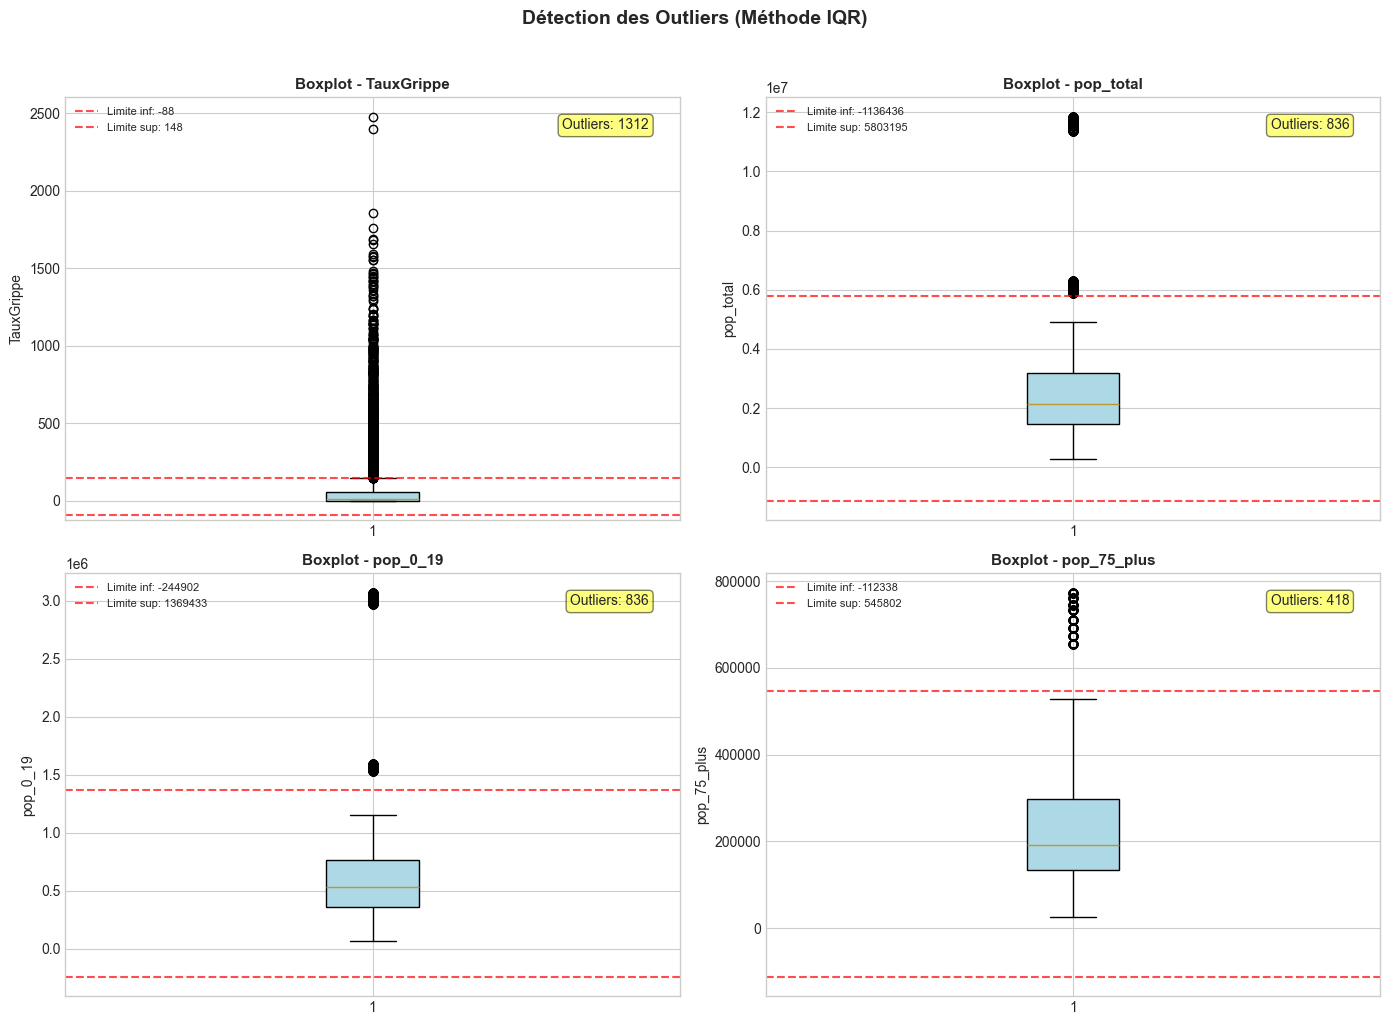

In [39]:
# Visualisation des outliers avec boxplots
key_numeric_cols = ['TauxGrippe', 'pop_total', 'pop_0_19', 'pop_75_plus']
key_numeric_cols = [c for c in key_numeric_cols if c in df_imputed.columns]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(key_numeric_cols):
    # Calcul des limites IQR
    Q1 = df_imputed[col].quantile(0.25)
    Q3 = df_imputed[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    # Boxplot
    bp = axes[i].boxplot(df_imputed[col].dropna(), vert=True, patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')
    
    # Lignes pour les limites
    axes[i].axhline(y=lower, color='red', linestyle='--', alpha=0.7, label=f'Limite inf: {lower:.0f}')
    axes[i].axhline(y=upper, color='red', linestyle='--', alpha=0.7, label=f'Limite sup: {upper:.0f}')
    
    axes[i].set_title(f'Boxplot - {col}', fontsize=11, fontweight='bold')
    axes[i].set_ylabel(col)
    axes[i].legend(fontsize=8)
    
    # Nombre d'outliers
    n_outliers = is_outlier(df_imputed, col).sum()
    axes[i].text(0.95, 0.95, f'Outliers: {n_outliers}', transform=axes[i].transAxes, 
                 ha='right', va='top', fontsize=10, 
                 bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

plt.suptitle('Détection des Outliers (Méthode IQR)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('detection_outliers.png', dpi=150, bbox_inches='tight')
plt.show()

In [40]:
# Analyse détaillée des outliers de TauxGrippe
print("📊 ANALYSE DÉTAILLÉE DES OUTLIERS - TauxGrippe")
print("=" * 60)

# Identifier les outliers
df_imputed['is_outlier_TauxGrippe'] = is_outlier(df_imputed, 'TauxGrippe')

outliers_df = df_imputed[df_imputed['is_outlier_TauxGrippe'] == 1]
print(f"\n🔍 Nombre d'outliers : {len(outliers_df)} ({len(outliers_df)/len(df_imputed)*100:.2f}%)")

print(f"\n📈 Statistiques des outliers :")
print(f"   Min    : {outliers_df['TauxGrippe'].min()}")
print(f"   Max    : {outliers_df['TauxGrippe'].max()}")
print(f"   Moyenne: {outliers_df['TauxGrippe'].mean():.2f}")

print(f"\n🗺️ Régions avec le plus d'outliers :")
print(outliers_df['region_name'].value_counts().head(10))

# Nettoyer la colonne temporaire
df_imputed.drop('is_outlier_TauxGrippe', axis=1, inplace=True)

📊 ANALYSE DÉTAILLÉE DES OUTLIERS - TauxGrippe

🔍 Nombre d'outliers : 1312 (14.27%)

📈 Statistiques des outliers :
   Min    : 148
   Max    : 2478
   Moyenne: 420.60

🗺️ Régions avec le plus d'outliers :
region_name
LIMOUSIN                      99
RHONE-ALPES                   94
ALSACE                        75
LANGUEDOC-ROUSSILLON          69
PROVENCE-ALPES-COTE-D-AZUR    69
NORD-PAS-DE-CALAIS            67
CHAMPAGNE-ARDENNE             65
ILE-DE-FRANCE                 63
AUVERGNE                      61
BRETAGNE                      61
Name: count, dtype: int64


## 11. Encodage des Variables Catégorielles

In [41]:
# Identification des variables catégorielles à encoder
print("📊 ENCODAGE DES VARIABLES CATÉGORIELLES")
print("=" * 60)

categorical_cols_to_encode = df_imputed.select_dtypes(include=['object']).columns.tolist()

print(f"\n🏷️ Variables catégorielles identifiées : {len(categorical_cols_to_encode)}")
for col in categorical_cols_to_encode:
    n_unique = df_imputed[col].nunique()
    print(f"   • {col}: {n_unique} modalités")

📊 ENCODAGE DES VARIABLES CATÉGORIELLES

🏷️ Variables catégorielles identifiées : 6
   • region_name: 22 modalités
   • month: 96 modalités
   • region_normalized: 22 modalités
   • region: 22 modalités
   • Mois_y: 96 modalités
   • Mois: 96 modalités


In [42]:
# Encodage avec LabelEncoder
df_encoded = df_imputed.copy()
label_encoders = {}

print("\n🔄 Encodage en cours (Label Encoding)...")
print("-" * 50)

for col in categorical_cols_to_encode:
    le = LabelEncoder()
    df_encoded[col + '_encoded'] = le.fit_transform(df_encoded[col].astype(str))
    label_encoders[col] = le
    print(f"  ✓ {col} → {col}_encoded")

print("\n✅ Encodage terminé !")


🔄 Encodage en cours (Label Encoding)...
--------------------------------------------------
  ✓ region_name → region_name_encoded
  ✓ month → month_encoded
  ✓ region_normalized → region_normalized_encoded
  ✓ region → region_encoded
  ✓ Mois_y → Mois_y_encoded
  ✓ Mois → Mois_encoded

✅ Encodage terminé !


In [43]:
# Exemple de mapping pour region_name
print("\n📋 EXEMPLE DE MAPPING : region_name")
print("=" * 60)

if 'region_name' in label_encoders:
    le = label_encoders['region_name']
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    for region, code in sorted(mapping.items(), key=lambda x: x[1]):
        print(f"  {code:2d} → {region}")


📋 EXEMPLE DE MAPPING : region_name
   0 → ALSACE
   1 → AQUITAINE
   2 → AUVERGNE
   3 → BASSE-NORMANDIE
   4 → BOURGOGNE
   5 → BRETAGNE
   6 → CENTRE
   7 → CHAMPAGNE-ARDENNE
   8 → CORSE
   9 → FRANCHE-COMTE
  10 → HAUTE-NORMANDIE
  11 → ILE-DE-FRANCE
  12 → LANGUEDOC-ROUSSILLON
  13 → LIMOUSIN
  14 → LORRAINE
  15 → MIDI-PYRENEES
  16 → NORD-PAS-DE-CALAIS
  17 → PAYS-DE-LA-LOIRE
  18 → PICARDIE
  19 → POITOU-CHARENTES
  20 → PROVENCE-ALPES-COTE-D-AZUR
  21 → RHONE-ALPES


In [44]:
# Aperçu du dataset encodé
print("\n📊 APERÇU DU DATASET APRÈS ENCODAGE")
print("=" * 60)
print(f"\nDimensions : {df_encoded.shape[0]} lignes × {df_encoded.shape[1]} colonnes")

# Afficher les colonnes encodées
encoded_cols = [col for col in df_encoded.columns if '_encoded' in col]
print(f"\nNouvelles colonnes encodées : {encoded_cols}")

df_encoded[['region_name', 'region_name_encoded']].head(10)


📊 APERÇU DU DATASET APRÈS ENCODAGE

Dimensions : 9196 lignes × 30 colonnes

Nouvelles colonnes encodées : ['region_name_encoded', 'month_encoded', 'region_normalized_encoded', 'region_encoded', 'Mois_y_encoded', 'Mois_encoded']


,region_name,region_name_encoded
0,ALSACE,0
1,AQUITAINE,1
2,AUVERGNE,2
3,BASSE-NORMANDIE,3
4,BOURGOGNE,4
5,BRETAGNE,5
6,CENTRE,6
7,CHAMPAGNE-ARDENNE,7
8,CORSE,8
9,FRANCHE-COMTE,9


## 12. Résumé et Conclusions

In [45]:
# Résumé final de l'EDA
print("="*80)
print("                    📊 RÉSUMÉ DE L'ANALYSE EXPLORATOIRE")
print("="*80)

print("\n📌 INFORMATIONS GÉNÉRALES")
print("-" * 40)
print(f"   • Nombre d'observations  : {df.shape[0]:,}")
print(f"   • Nombre de variables    : {df.shape[1]}")
print(f"   • Période couverte       : {df['year'].min()} - {df['year'].max()}")
print(f"   • Nombre de régions      : {df['region_name'].nunique()}")

print("\n📌 VARIABLE CIBLE : TauxGrippe")
print("-" * 40)
print(f"   • Moyenne   : {df['TauxGrippe'].mean():.2f}")
print(f"   • Médiane   : {df['TauxGrippe'].median():.2f}")
print(f"   • Min - Max : {df['TauxGrippe'].min()} - {df['TauxGrippe'].max()}")
print(f"   • Écart-type: {df['TauxGrippe'].std():.2f}")

print("\n📌 VALEURS MANQUANTES")
print("-" * 40)
total_missing = df.isnull().sum().sum()
total_cells = df.shape[0] * df.shape[1]
print(f"   • Total valeurs manquantes : {total_missing:,}")
print(f"   • Pourcentage global       : {total_missing/total_cells*100:.2f}%")
print(f"   • Colonnes concernées      : {df.columns[df.isnull().any()].tolist()}")

print("\n📌 OUTLIERS (TauxGrippe)")
print("-" * 40)
n_outliers = is_outlier(df, 'TauxGrippe').sum()
print(f"   • Nombre d'outliers : {n_outliers} ({n_outliers/len(df)*100:.2f}%)")

print("\n📌 OBSERVATIONS CLÉS")
print("-" * 40)
print("   ✓ Distribution asymétrique du taux de grippe (skewness positive)")
print("   ✓ Forte saisonnalité : pics en hiver (décembre-février)")
print("   ✓ Variabilité importante entre régions")
print("   ✓ Données démographiques et requêtes Google comme features")

print("\n" + "="*80)
print("                         ✅ FIN DE L'ANALYSE EDA")
print("="*80)

                    📊 RÉSUMÉ DE L'ANALYSE EXPLORATOIRE

📌 INFORMATIONS GÉNÉRALES
----------------------------------------
   • Nombre d'observations  : 9,196
   • Nombre de variables    : 24
   • Période couverte       : 2004 - 2011
   • Nombre de régions      : 22

📌 VARIABLE CIBLE : TauxGrippe
----------------------------------------
   • Moyenne   : 77.55
   • Médiane   : 10.00
   • Min - Max : 0 - 2478
   • Écart-type: 180.94

📌 VALEURS MANQUANTES
----------------------------------------
   • Total valeurs manquantes : 3,344
   • Pourcentage global       : 1.52%
   • Colonnes concernées      : ['Mois_y', 'requete_grippe_x', 'requete_grippe_aviaire_vaccin_x', 'requete_grippe_aviaire_vaccin_porcine_porc_H1N1_AH1N1_A_mexicaine_Mexique_pandemie_x', 'Mois', 'requete_grippe_y', 'requete_grippe_aviaire_vaccin_y', 'requete_grippe_aviaire_vaccin_porcine_porc_H1N1_AH1N1_A_mexicaine_Mexique_pandemie_y']

📌 OUTLIERS (TauxGrippe)
----------------------------------------
   • Nombre d'outliers :

In [46]:
# Sauvegarde du dataset nettoyé (optionnel)
df_encoded.to_csv('train_final_clean.csv', index=False)
print("✅ Dataset nettoyé sauvegardé : train_final_clean.csv")

✅ Dataset nettoyé sauvegardé : train_final_clean.csv
